In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [4]:
# Paths to the dataset
data_dir = 'augmented_data'

# Hyperparameters
img_size = 224  # MobileNet standard input size
batch_size = 32
epochs = 10
learning_rate = 0.0001


In [5]:
# Data augmentation and rescaling
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Creating the training and validation generators
train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (yes/no)
    subset='training'     # Set this as training set
)

validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (yes/no)
    subset='validation'   # Set this as validation set
)


Found 2281 images belonging to 2 classes.
Found 570 images belonging to 2 classes.


In [6]:
# Load MobileNet model without top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base layers (fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (yes/no)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 29s 2us/step


In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.7341 - loss: 0.5091 - val_accuracy: 0.8107 - val_loss: 0.4025
Epoch 2/10
 1/71 ━━━━━━━━━━━━━━━━━━━━ 29s 428ms/step - accuracy: 0.8750 - loss: 0.2689

D:\Python\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2689 - val_accuracy: 0.8462 - val_loss: 0.3096
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 534ms/step - accuracy: 0.9413 - loss: 0.1878 - val_accuracy: 0.8346 - val_loss: 0.3571
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9688 - loss: 0.1486 - val_accuracy: 1.0000 - val_loss: 0.1581
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 532ms/step - accuracy: 0.9695 - loss: 0.1290 - val_accuracy: 0.8438 - val_loss: 0.3442
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9688 - loss: 0.1321 - val_accuracy: 0.8846 - val_loss: 0.3101
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 585ms/step - accuracy: 0.9841 - loss: 0.0898 - val_accuracy: 0.8585 - val_loss: 0.3327


In [10]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - accuracy: 0.8542 - loss: 0.3365
Validation Accuracy: 84.39%


In [11]:
# After training the model, save it to an .h5 file
model.save('brain_tumor_detection_mobilenet.h5')
print("Model saved successfully as brain_tumor_detection_mobilenet.h5")


Model saved successfully as brain_tumor_detection_mobilenet.h5


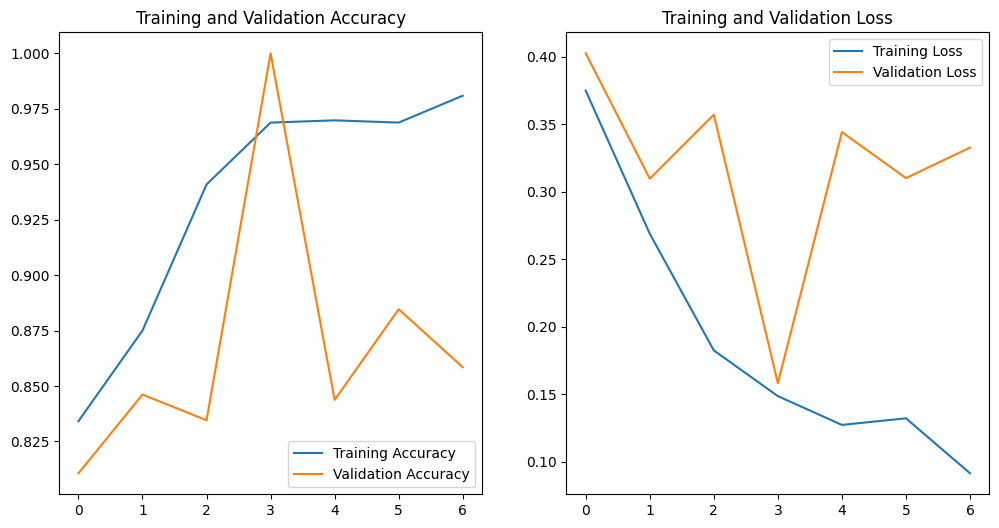

In [12]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
